# Basic count program
* Made by Vivian Tao
* Last update by Vivian Tao (June 17, 2025)

This file counts the number of living and dead bacteria based on the diagonal size of the trajectory.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
from scipy.optimize import curve_fit

In [2]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]

# for files with RGB
#frames = gray(pims.open("data/day6_mar3/*.tif*"))

# change filename here for other files
frames = pims.open("../../ambdata/day5_background_orig/*.tif*")

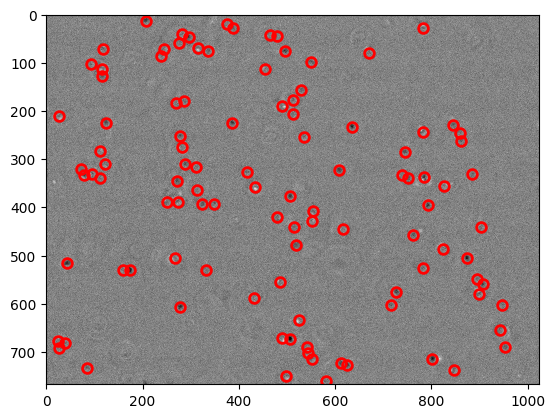

106


<Figure size 640x480 with 0 Axes>

In [3]:
BACT_SIZE = 13 # must be an odd integer, better to be on the larger end
MIN_MASS = 100000
sub_drift = True

upp = 0.25 # upp is microns per pixel
fps = 10 # fps is frames per second

# prints first frame with annotations - use this to check if BACT_SIZE and MIN_MASS are appropriate for this video and adjust as necessary
for i in [0]: # or use [::50] for every 50th frame
    f = tp.locate(frames[i], BACT_SIZE, invert=True, minmass=MIN_MASS)
    plt.imshow(frames[i])
    tp.annotate(f, frames[i], plot_style={'markersize': 7})
    plt.clf()

print(len(f))


In [4]:
# finds all bacteria in all frames
f = tp.batch(frames[:], BACT_SIZE, invert=True, minmass=MIN_MASS)
tp.quiet(suppress=False)

Frame 123: 110 features


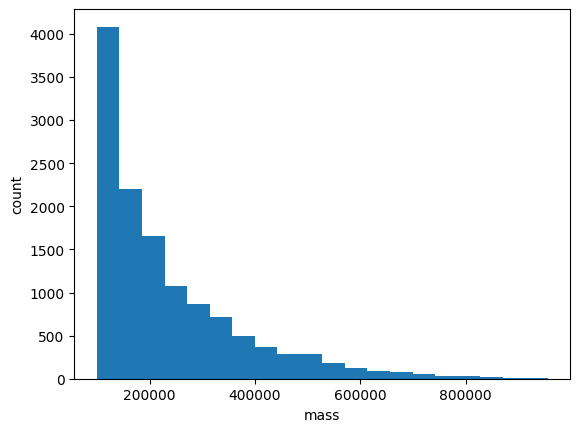

<Figure size 640x480 with 0 Axes>

In [5]:
# plots the mass distribution of all bacteria
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')
plt.show()
plt.clf()

In [6]:
# links trajectories, filters out short trajectories, and subtracts drift
t = tp.link_df(f, 20, memory=10)
t1 = tp.filter_stubs(t, 5)
t1 = tp.subtract_drift(t1)

if sub_drift == True:
	t1.index.names = ["frame", "index"] # the data structure changes when you subtract drift, we're switching it back

Frame 123: 110 trajectories present.


In [7]:
# this is what the trajectory dataframe looks like now!
t1

y           x           mass      size       ecc  \
frame index                                                              
0     0       11.791483  206.532224  436128.212625  3.379827  0.251542   
      1      530.297627  331.909153  104958.249897  3.647242  0.048287   
      3      526.888246  782.023152  159821.172386  3.354865  0.295705   
      4      516.005888   42.550733  519667.863729  3.454186  0.220357   
      6      505.361503  873.897617  585204.506547  2.931759  0.103031   
...                 ...         ...            ...       ...       ...   
123   500    589.992194  439.528338  130933.441326  3.705612  0.338630   
      510    434.075173  498.111785  131738.360022  3.864033  0.073642   
      512    329.842590   52.524656  103476.770228  3.613812  0.434894   
      513    699.879372   45.525381  150251.490046  3.139135  0.321044   
      517     13.055109  722.290886  197205.080685  2.939449  0.084192   

                   signal   raw_mass        ep  frame  particle  
frame index                                                      
0     0       9962.138973  1310461.0       NaN      0         0  
      1       2277.060337   526035.0       NaN      0         1  
      3       3771.381183   511620.0       NaN      0         3  
      4      11242.985413  1549705.0       NaN      0         4  
      6      16508.687441  1601647.0       NaN      0         6  
...                   ...        ...       ...    ...       ...  
123   500     2861.933144   329908.0  0.096832    123       500  
      510     2593.626912   513675.0  0.078155    123       510  
      512     2951.368554   343810.5  0.095112    123       512  
      513     4650.641359   405155.5  0.088201    123       513  
      517     6081.607930   681060.5  0.066476    123       517  

[12242 rows x 10 columns]

In [8]:
num_trajectories = t1["particle"].max()

traj_range = np.linspace(0, num_trajectories, num=num_trajectories+1)
arr = []
for i in traj_range:
    if not t1[t1['particle']==i].empty:
        arr.append(i)
arr = np.array(arr)
# arr stores numbers of all particles with non-empty trajectories


/Users/viviantao/Documents/Johns Hopkins/research/MTB/count/.venv/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/viviantao/Documents/Johns Hopkins/research/MTB/count/.venv/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


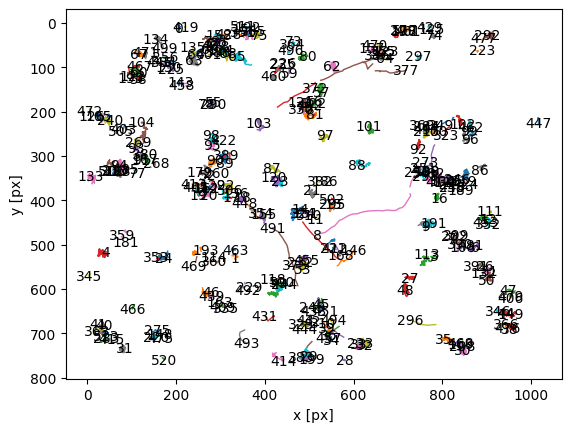

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [9]:
# plots trajectories with labels in original orientation
tp.plot_traj(t1, label=True)

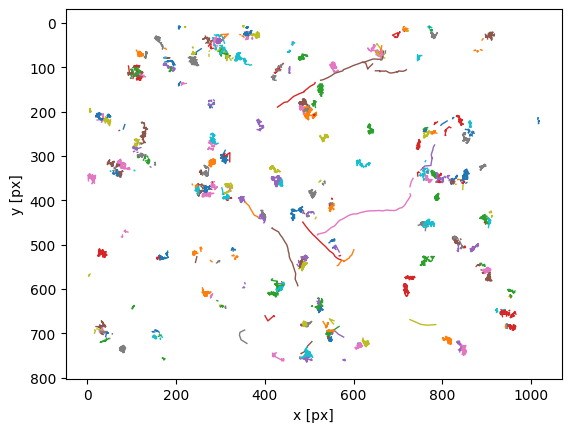

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [10]:
# plots trajectories without labels in original orientation
tp.plot_traj(t1, label=False)

In [11]:
def get_diagonal_size(array):
    lengths = []

    for particle in array:
        lengths.append(tp.diagonal_size(t1[t1["particle"] == particle], pos_columns=None, t_column='frame'))

    lengths = np.array(lengths)
    return lengths

def linear_model(x, A, B):
	y = A + B * x
	return y

# returns best fit power law exponents - 1 is linear = brownian motion
def fit_powerlaw(x, y):
	x = np.log(x)
	y = np.log(y)
	fit, dfit = curve_fit(linear_model, x, y, absolute_sigma = True)
	return fit[1], np.sqrt(dfit[1,1])


# returns numpy array of powers for each particle, with 0 if the power cannot be calculated (not enough frames) and 
# a numpy array of the maximum msd for each particle
def calc_msd(array):
	power = []
	lengths = []
	max_msd = []
	for particle in array:
		a = tp.msd(t1[t1['particle']==particle], upp, fps)
		a = a[a['msd'] != 0] # removes rows of a specific lagtime where parts of calculation includes NaN's or inf's.
		x = a['lagt']
		y = a['msd']
		lengths.append(len(x))
		if len(x) > 10: #and not np.any(y==0):
			c, a = fit_powerlaw(x, y)
			power.append(c)
			max_msd.append(np.max(y))
		else:
			power.append(0)
	power = np.array(power)
	max_msd = np.array(max_msd)
	return power, max_msd


total_diagonal_lengths = get_diagonal_size(arr)
total_msd_powers, total_max_msd = calc_msd(arr)

total = pd.DataFrame({'particle': arr, 'diagonal size': total_diagonal_lengths, 'msd power': total_msd_powers})

In [12]:
# calculates the number of living and dead particles based on diagonal size
def diagonal_size_strat(cutoff):
    numLiving = 0
    numDead = 0
    livinglist  = []
    deadlist = []
    zeros = []

    for index, row in total.iterrows():
        if row['diagonal size'] == 0:
            zeros.append(row['particle'])
        elif row['diagonal size'] < cutoff:
            numDead += 1
            deadlist.append(row['particle'])
        else:
            numLiving += 1
            livinglist.append(row['particle'])

    return numLiving, numDead, livinglist, deadlist

# calculates the number of living and dead particles based on msd power law exponent 
def msd_strat(cutoff):
    numLiving = 0
    numDead = 0
    livinglist  = []
    deadlist = []
    zeros = []

    for index, row in total.iterrows():
        if row['msd power'] == 0:
            zeros.append(row['particle'])
        elif row['msd power'] < cutoff:
            numDead += 1
            deadlist.append(row['particle'])
        else:
            numLiving += 1
            livinglist.append(row['particle'])

    return numLiving, numDead, livinglist, deadlist

In [15]:
numLiving, numDead, livinglist, deadlist = msd_strat(1.1)
print("Diagonal Size:")
print(str(numLiving) + " live bacteria found")
print(str(numDead) + " dead bacteria found")
print("percentage alive: %2.2f %%" % (numLiving * 100 / (numLiving + numDead)))
print("total bacteria: %d" % (numDead + numLiving))

print("\n")

numLiving, numDead, livinglist, deadlist = diagonal_size_strat(60)
print("Diagonal Size:")
print(str(numLiving) + " live bacteria found")
print(str(numDead) + " dead bacteria found")
print("percentage alive: %2.2f %%" % (numLiving * 100 / (numLiving + numDead)))
print("total bacteria: %d" % (numDead + numLiving))

Diagonal Size:
36 live bacteria found
214 dead bacteria found
percentage alive: 14.40 %
total bacteria: 250


Diagonal Size:
7 live bacteria found
276 dead bacteria found
percentage alive: 2.47 %
total bacteria: 283


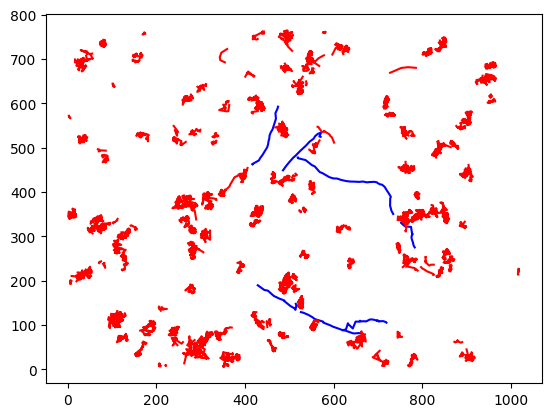

<Figure size 640x480 with 0 Axes>

In [16]:
# plot trajectories for diagonal size classification
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
for i in livinglist:
    plt.plot(t1[t1['particle']==i]['x'], t1[t1['particle']==i]['y'], '-b', label="living")
for i in deadlist:
    plt.plot(t1[t1['particle']==i]['x'], t1[t1['particle']==i]['y'], '-r', label="dead")
plt.savefig("trajectories.pdf")
plt.show()
plt.clf()

# ~END OF FILE~